In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


# Stats / classical
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Prophet
from prophet import Prophet


# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler


# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping


# Volatility (optional)
from arch import arch_model

In [3]:
# 2. Project objective (print)
project_objective = '''
Objective: Forecast daily Brent crude closing prices (USD per barrel) using classical and ML/DL models
- Compare SARIMA, Prophet, XGBoost, and GRU
- Evaluate 1-day and multi-step (7, 30 days) forecasting
- Provide simple backtesting and a final ensemble
'''
print(project_objective)


Objective: Forecast daily Brent crude closing prices (USD per barrel) using classical and ML/DL models
- Compare SARIMA, Prophet, XGBoost, and GRU
- Evaluate 1-day and multi-step (7, 30 days) forecasting
- Provide simple backtesting and a final ensemble



In [4]:
import yfinance as yf

ticker = "BZ=F"
df = yf.download(
    ticker,
    start="2014-01-01",
    end="2025-10-31",
    auto_adjust=True
)

# Flatten columns (remove ticker level)
df.columns = df.columns.get_level_values(0)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,107.779999,111.320000,107.690002,110.800003,5131
2014-01-03,106.889999,108.620003,106.779999,107.919998,5641
2014-01-06,106.730003,107.949997,106.580002,107.040001,7015
2014-01-07,107.349998,107.709999,106.910004,107.180000,4075
2014-01-08,107.150002,107.919998,107.010002,107.449997,5124


In [5]:
print("\n----- Tail -----")
display(df.tail())


----- Tail -----


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-10-24,65.940002,66.769997,65.440002,65.870003,38354
2025-10-27,65.620003,66.599998,65.080002,66.260002,32237
2025-10-28,64.400002,65.790001,64.000000,65.790001,33807
2025-10-29,64.919998,65.379997,63.930000,64.489998,16478
2025-10-30,65.000000,65.160004,64.059998,64.849998,10024


In [6]:
#MISSING TERMS
print("Missing per column:\n", df.isna().sum())

Missing per column:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [7]:
# Basic structure
print("----- Data Info -----")
print(df.info())

----- Data Info -----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2975 entries, 2014-01-02 to 2025-10-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2975 non-null   float64
 1   High    2975 non-null   float64
 2   Low     2975 non-null   float64
 3   Open    2975 non-null   float64
 4   Volume  2975 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 139.5 KB
None


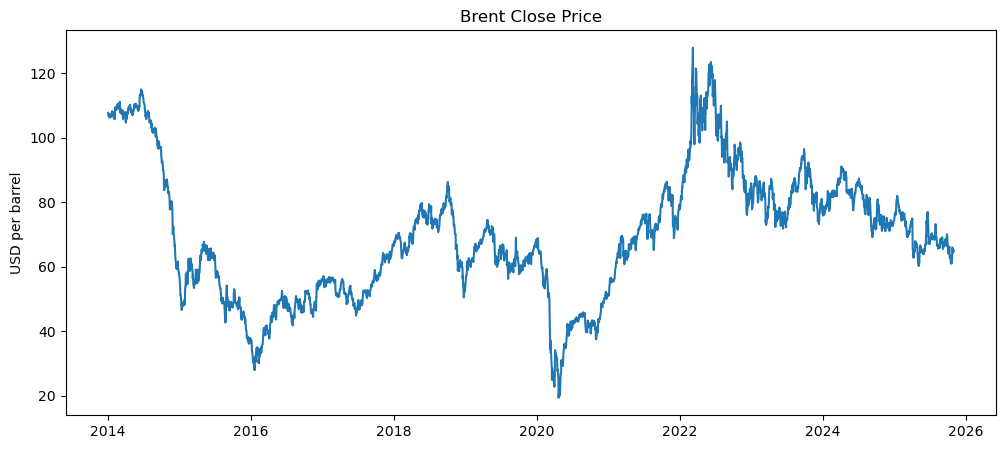

In [8]:
# 4. Quick EDA
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title('Brent Close Price')
plt.ylabel('USD per barrel')
plt.show()

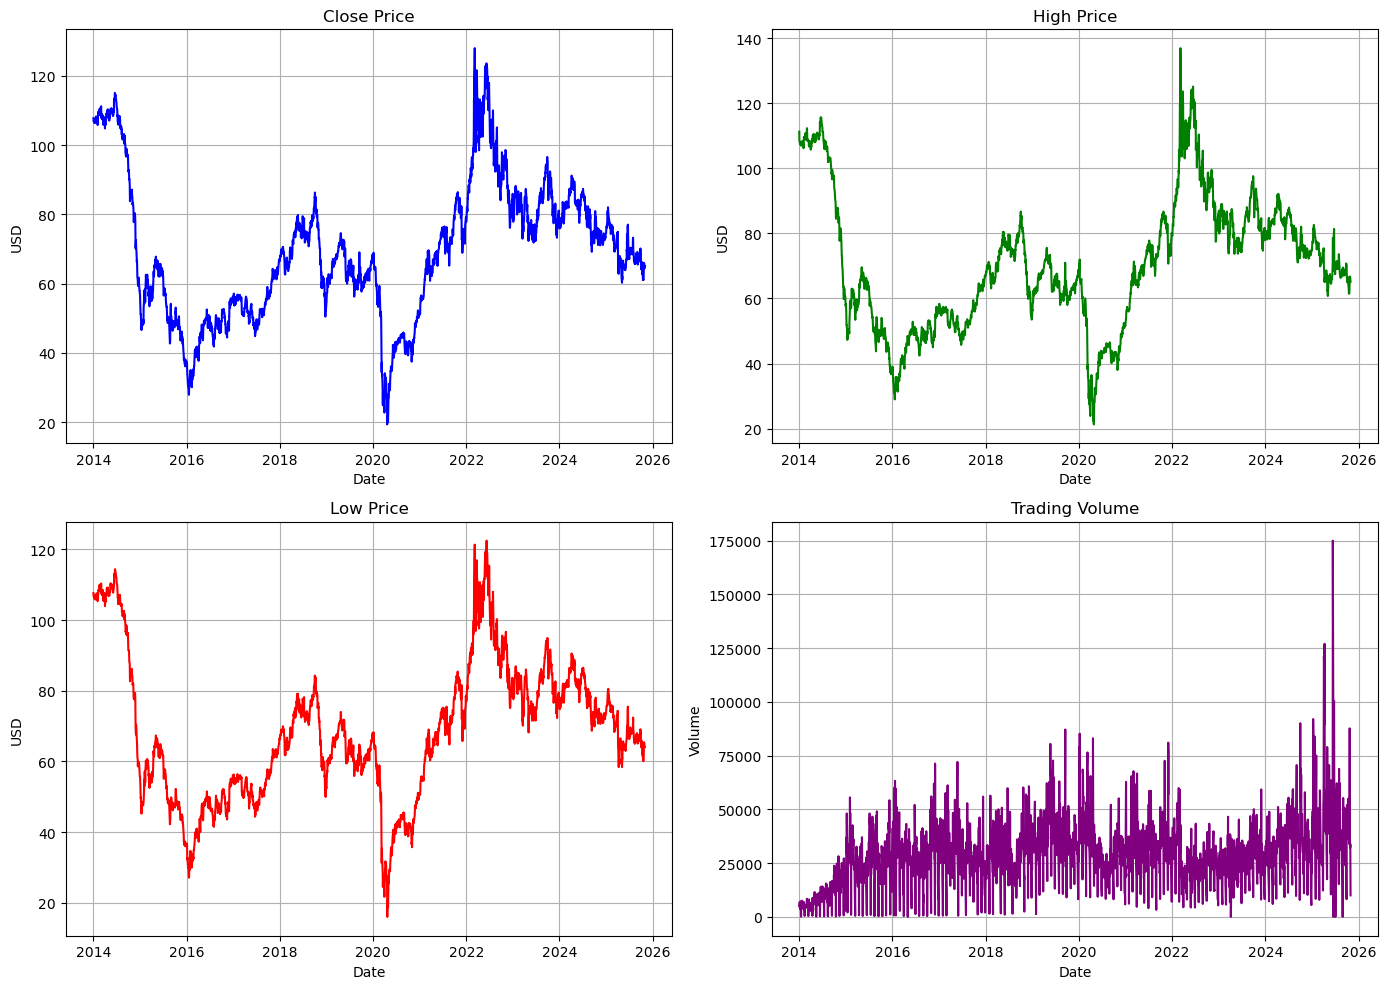

In [9]:
plt.figure(figsize=(14,10))

# --- Close ---
plt.subplot(2,2,1)
plt.plot(df['Close'], color='blue')
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)

# --- High ---
plt.subplot(2,2,2)
plt.plot(df['High'], color='green')
plt.title('High Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)

# --- Low ---
plt.subplot(2,2,3)
plt.plot(df['Low'], color='red')
plt.title('Low Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)

# --- Volume ---
plt.subplot(2,2,4)
plt.plot(df['Volume'], color='purple')
plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
#  Create Return column
df['Return'] = df['Close'].pct_change()

# 2. Check if column exists
print(df.columns)



Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Return'], dtype='object', name='Price')


In [11]:
# 3. Display summary stats
print("Return stats:")
print(df['Return'].describe())
print("Skewness:", df['Return'].skew())
print("Kurtosis:", df['Return'].kurtosis())

Return stats:
count    2974.000000
mean        0.000124
std         0.024124
min        -0.244036
25%        -0.010680
50%         0.000602
75%         0.011708
max         0.210186
Name: Return, dtype: float64
Skewness: -0.37974264301215904
Kurtosis: 12.338963941327654


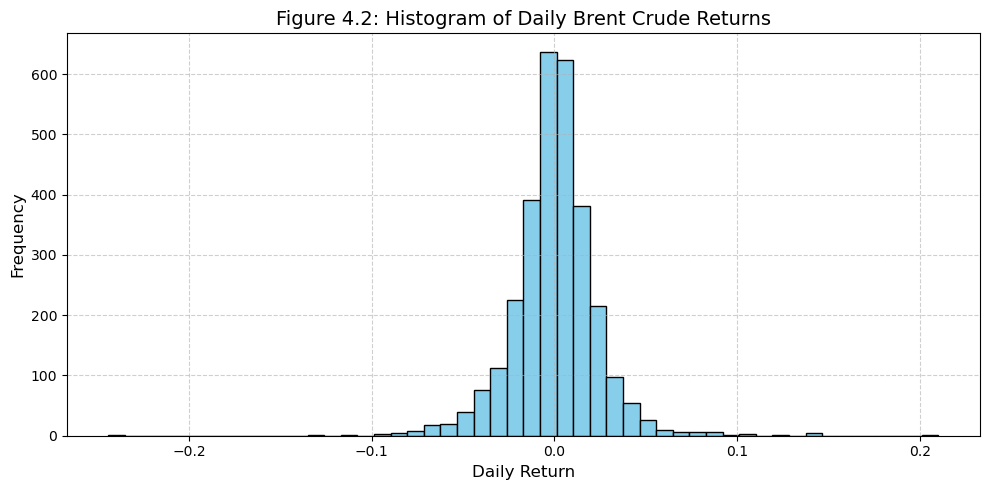

In [12]:
# --- Figure 4.2: Histogram of daily returns ---
plt.figure(figsize=(10,5))
plt.hist(df['Return'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Figure 4.2: Histogram of Daily Brent Crude Returns', fontsize=14)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
# Daily returns
df['Return'] = df['Close'].pct_change()

print("Return stats:\n", df['Return'].describe())

Return stats:
 count    2974.000000
mean        0.000124
std         0.024124
min        -0.244036
25%        -0.010680
50%         0.000602
75%         0.011708
max         0.210186
Name: Return, dtype: float64


In [14]:
adf_result = adfuller(df['Close'].dropna())
print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF statistic: -2.407427113116233
p-value: 0.1396511245731611


In [15]:
# --- Table 4.2: Augmented Dickey-Fuller Test Results ---
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'].dropna())
adf_table = pd.DataFrame({
    'Series': ['Close Price Level'],
    'ADF Statistic': [adf_result[0]],
    'p-value': [adf_result[1]],
    'Used Lag': [adf_result[2]],
    'Number of Observations': [adf_result[3]],
    'Critical Value (1%)': [adf_result[4]['1%']],
    'Critical Value (5%)': [adf_result[4]['5%']],
    'Critical Value (10%)': [adf_result[4]['10%']]
})

print("ADF Test Results:")
print(adf_table)

ADF Test Results:
              Series  ADF Statistic   p-value  Used Lag  \
0  Close Price Level      -2.407427  0.139651         6   

   Number of Observations  Critical Value (1%)  Critical Value (5%)  \
0                    2968            -3.432555            -2.862514   

   Critical Value (10%)  
0             -2.567289  


In [16]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'].dropna())

adf_table = pd.DataFrame({
    'Series': ['Brent Crude Closing Price'],
    'ADF Statistic': [adf_result[0]],
    'p-value': [adf_result[1]],
    'Used Lag': [adf_result[2]],
    'Number of Observations': [adf_result[3]],
    'Critical Value (1%)': [adf_result[4]['1%']],
    'Critical Value (5%)': [adf_result[4]['5%']],
    'Critical Value (10%)': [adf_result[4]['10%']]
})

print("Table 4.2: Augmented Dickey-Fuller Test Results")
print(adf_table)


Table 4.2: Augmented Dickey-Fuller Test Results
                      Series  ADF Statistic   p-value  Used Lag  \
0  Brent Crude Closing Price      -2.407427  0.139651         6   

   Number of Observations  Critical Value (1%)  Critical Value (5%)  \
0                    2968            -3.432555            -2.862514   

   Critical Value (10%)  
0             -2.567289  


In [17]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
adf_result = adfuller(df['Close'].dropna())

# Create table
adf_table = pd.DataFrame({
    'Series': ['Brent Crude Closing Price'],
    'ADF Statistic': [adf_result[0]],
    'p-value': [adf_result[1]],
    'Used Lag': [adf_result[2]],
    'Number of Observations': [adf_result[3]],
    'Critical Value (1%)': [adf_result[4]['1%']],
    'Critical Value (5%)': [adf_result[4]['5%']],
    'Critical Value (10%)': [adf_result[4]['10%']]
})

print("Table 4.2: Augmented Dickey-Fuller Test Results")
print(adf_table)


Table 4.2: Augmented Dickey-Fuller Test Results
                      Series  ADF Statistic   p-value  Used Lag  \
0  Brent Crude Closing Price      -2.407427  0.139651         6   

   Number of Observations  Critical Value (1%)  Critical Value (5%)  \
0                    2968            -3.432555            -2.862514   

   Critical Value (10%)  
0             -2.567289  


In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations:", adf_result[3])
print("Critical Values:", adf_result[4])


ADF Statistic: -2.407427113116233
p-value: 0.1396511245731611
Used Lag: 6
Number of Observations: 2968
Critical Values: {'1%': np.float64(-3.4325551767781697), '5%': np.float64(-2.862514302929651), '10%': np.float64(-2.5672886477185215)}


In [19]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'].dropna())

adf_table = pd.DataFrame({
    'Series': ['Brent Crude Closing Price'],
    'ADF Statistic': [adf_result[0]],
    'p-value': [adf_result[1]],
    'Used Lag': [adf_result[2]],
    'Number of Observations': [adf_result[3]],
    'Critical Value (1%)': [adf_result[4]['1%']],
    'Critical Value (5%)': [adf_result[4]['5%']],
    'Critical Value (10%)': [adf_result[4]['10%']]
})

print("Table 4.2: Augmented Dickey-Fuller Test Results")
print(adf_table)

Table 4.2: Augmented Dickey-Fuller Test Results
                      Series  ADF Statistic   p-value  Used Lag  \
0  Brent Crude Closing Price      -2.407427  0.139651         6   

   Number of Observations  Critical Value (1%)  Critical Value (5%)  \
0                    2968            -3.432555            -2.862514   

   Critical Value (10%)  
0             -2.567289  


<Figure size 1200x800 with 0 Axes>

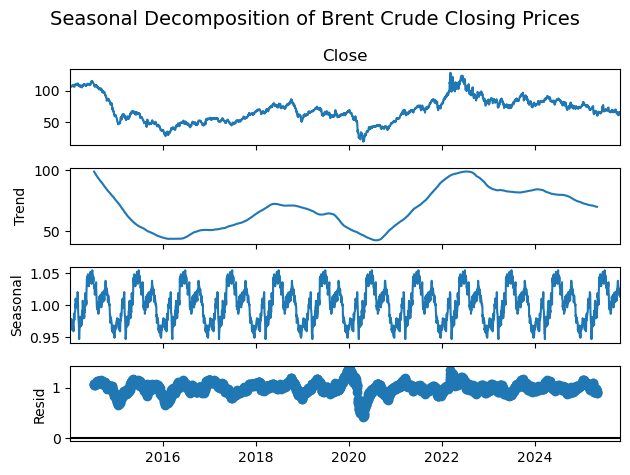

In [20]:


from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Seasonal decomposition (yearly ~252 trading days)
res = seasonal_decompose(df['Close'].dropna(), model='multiplicative', period=252)

# Adjust figure size
plt.figure(figsize=(12,8))

# Plot decomposition
res.plot()
plt.suptitle('Seasonal Decomposition of Brent Crude Closing Prices', fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
# Stationarity test
adf_result = adfuller(df['Close'].dropna())
print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF statistic: -2.407427113116233
p-value: 0.1396511245731611


In [22]:
# --- Table 4.3: Baseline Forecast Accuracy ---
naive_metrics = evaluate_forecasts(test['Close'], naive_pred)
rolling_metrics = evaluate_forecasts(test['Close'], rolling_pred_series)

print("\nTable 4.3: Baseline Forecast Accuracy")
print("Naive Forecast:")
print("RMSE:", naive_metrics['rmse'])
print("MAE :", naive_metrics['mae'])

print("\nRolling Mean (7-day):")
print("RMSE:", rolling_metrics['rmse'])
print("MAE :", rolling_metrics['mae'])


NameError: name 'evaluate_forecasts' is not defined

In [23]:
# 5. Preprocessing functions

def make_supervised(series, lags=30, horizon=1):
    """Create supervised learning DataFrame with lag features and target at horizon"""
    
    df_sup = pd.DataFrame({'y': series})
    
    # Create lag features
    for i in range(1, lags + 1):
        df_sup[f'lag_{i}'] = df_sup['y'].shift(i)
    
    # Create future target columns
    for h in range(1, horizon + 1):
        df_sup[f'y_plus_{h}'] = df_sup['y'].shift(-h)
    
    return df_sup


In [24]:
sup = make_supervised(df['Close'], lags=30, horizon=7)
print("Supervised sample:\n", sup.dropna().head())

Supervised sample:
                      y       lag_1       lag_2       lag_3       lag_4  \
Date                                                                     
2014-02-19  110.470001  108.730003  108.730003  108.790001  108.680000   
2014-02-20  110.300003  110.470001  108.730003  108.730003  108.790001   
2014-02-21  109.849998  110.300003  110.470001  108.730003  108.730003   
2014-02-24  110.639999  109.849998  110.300003  110.470001  108.730003   
2014-02-25  109.510002  110.639999  109.849998  110.300003  110.470001   

                 lag_5       lag_6       lag_7       lag_8       lag_9  ...  \
Date                                                                    ...   
2014-02-19  108.629997  109.570000  107.190002  106.250000  105.779999  ...   
2014-02-20  108.680000  108.629997  109.570000  107.190002  106.250000  ...   
2014-02-21  108.790001  108.680000  108.629997  109.570000  107.190002  ...   
2014-02-24  108.730003  108.790001  108.680000  108.629997  109.57

In [25]:
# 6. Train-test split (time-based)
def time_split(df, train_ratio=0.8):
    n = len(df)
    train_end = int(n*train_ratio)
    train = df.iloc[:train_end].copy()
    test = df.iloc[train_end:].copy()
    return train, test


train, test = time_split(df['Close'].to_frame(), train_ratio=0.8)
print('Train length:', len(train), 'Test length:', len(test))

Train length: 2380 Test length: 595


In [26]:
# 7. Baseline: Naive & Rolling mean

def evaluate_forecasts(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae}


naive_pred = test['Close'].shift(1).fillna(method='bfill')
baseline_metrics = evaluate_forecasts(test['Close'], naive_pred)

print("Naive baseline:", baseline_metrics)


Naive baseline: {'rmse': np.float64(1.3785180912001225), 'mae': 1.0337310278115153}


C:\Users\HP\AppData\Local\Temp\ipykernel_11344\1173991096.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_pred = test['Close'].shift(1).fillna(method='bfill')


In [27]:
# Rolling mean 7-day
rolling_pred = train['Close'].iloc[-7:].mean()
rolling_pred_series = pd.Series(rolling_pred, index=test.index)
print('Rolling mean (constant) RMSE:', evaluate_forecasts(test['Close'], rolling_pred_series))

Rolling mean (constant) RMSE: {'rmse': np.float64(8.162055941309028), 'mae': 6.840494647260759}


In [28]:
def select_sarimax_order(series, pdq_range=(0, 2), seasonal_pdq_range=(0, 1), m=7):
    """Try small grid of orders and return best (lowest AIC). Keeps ranges small for speed."""
    
    best_aic = np.inf
    best_order = None
    best_seasonal = None

    for p in range(pdq_range[0], pdq_range[1] + 1):
        for d in range(0, 2):
            for q in range(pdq_range[0], pdq_range[1] + 1):

                for P in range(seasonal_pdq_range[0], seasonal_pdq_range[1] + 1):
                    for D in range(0, 2):
                        for Q in range(seasonal_pdq_range[0], seasonal_pdq_range[1] + 1):

                            try:
                                model = SARIMAX(
                                    series,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, m),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                res = model.fit(disp=False)

                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_order = (p, d, q)
                                    best_seasonal = (P, D, Q, m)

                            except Exception:
                                continue

    return best_order, best_seasonal




In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure datetime index has frequency
train = train.asfreq('D')

# Suppose these orders were selected
order = (1, 1, 1)
seasonal_order = (1, 0, 0, 7)

# Initialize SARIMAX
sarimax = SARIMAX(train['Close'],
                  order=order,
                  seasonal_order=seasonal_order,
                  enforce_stationarity=False,
                  enforce_invertibility=False)

# Fit with more iterations to avoid convergence warnings
sarimax_res = sarimax.fit(disp=False, method_kwargs={"maxiter": 1000})

# Check summary
print(sarimax_res.summary())


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3459
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood               -4476.892
Date:                            Mon, 15 Dec 2025   AIC                           8961.784
Time:                                    20:57:20   BIC                           8986.369
Sample:                                01-02-2014   HQIC                          8970.565
                                     - 06-22-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2688      0.148      1.817      0.069      -0.021       0.559
ma.L1         -0.3501      0.140   

In [30]:
# Forecast over test period
n_test = len(test)
sarima_pred = sarimax_res.get_forecast(steps=n_test).predicted_mean
sarima_pred.index = test.index
sarima_metrics = evaluate_forecasts(test['Close'], sarima_pred)
print('SARIMAX metrics:', sarima_metrics)

SARIMAX metrics: {'rmse': np.float64(8.363821957871856), 'mae': 6.956551210028621}


In [31]:
# --- Extract SARIMA parameter estimates ---
sarima_params = pd.DataFrame({
    'Estimate': sarimax_res.params,
    'Std_Error': sarimax_res.bse,
    'p_value': sarimax_res.pvalues
})

print("\nTable 4.4: SARIMA Parameter Estimates")
print(sarima_params)



Table 4.4: SARIMA Parameter Estimates
         Estimate  Std_Error       p_value
ar.L1    0.268832   0.147993  6.929084e-02
ma.L1   -0.350075   0.139502  1.209121e-02
ar.S.L7 -0.062900   0.012680  7.031199e-07
sigma2   2.052930   0.028162  0.000000e+00


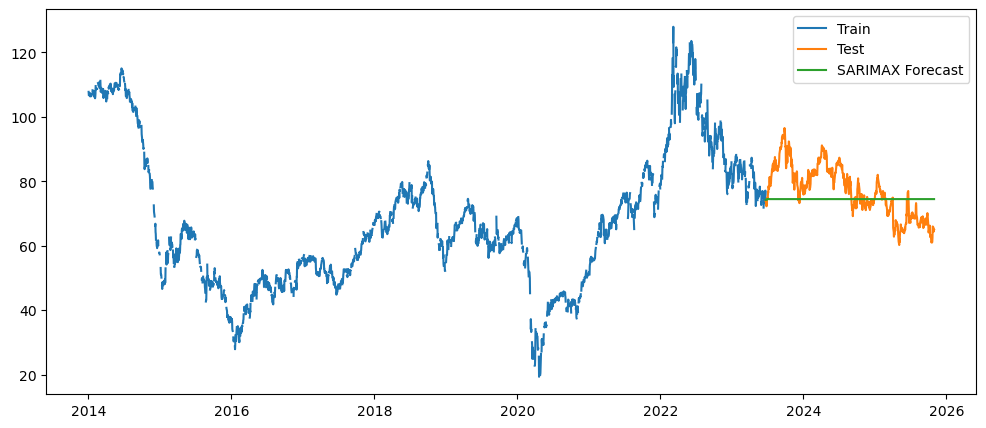

In [32]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMAX Forecast')
plt.legend()
plt.show()

In [33]:
# --- Table 4.5: SARIMA Forecast Accuracy ---
print("\nTable 4.5: SARIMA Forecast Accuracy")
print("RMSE:", sarima_metrics['rmse'])
print("MAE :", sarima_metrics['mae'])


Table 4.5: SARIMA Forecast Accuracy
RMSE: 8.363821957871856
MAE : 6.956551210028621


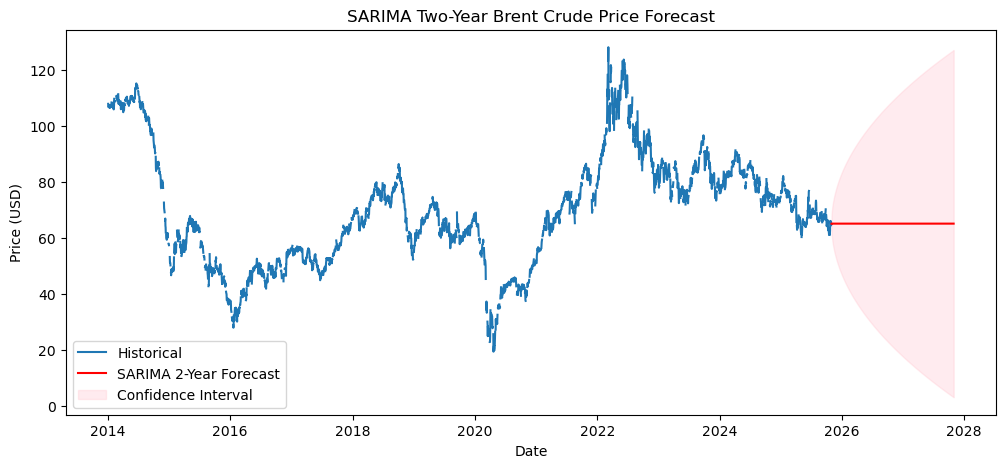

In [34]:
# --- SARIMA Two-Year Forecast ---

# Ensure daily frequency
full_series = df['Close'].asfreq('D')

# Fit SARIMA on full dataset
sarimax_full = SARIMAX(
    full_series,
    order=(1,1,1),
    seasonal_order=(1,0,0,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_full_res = sarimax_full.fit(disp=False)

# Forecast next 2 years (730 days)
n_future = 730
sarima_forecast_2yr = sarimax_full_res.get_forecast(steps=n_future)

sarima_2yr_mean = sarima_forecast_2yr.predicted_mean
sarima_2yr_ci = sarima_forecast_2yr.conf_int()

# Plot
plt.figure(figsize=(12,5))
plt.plot(full_series.index, full_series, label='Historical')
plt.plot(sarima_2yr_mean.index, sarima_2yr_mean, label='SARIMA 2-Year Forecast', color='red')
plt.fill_between(
    sarima_2yr_ci.index,
    sarima_2yr_ci.iloc[:,0],
    sarima_2yr_ci.iloc[:,1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('SARIMA Two-Year Brent Crude Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [35]:
# --- Prepare data for Prophet ---
df_prophet = df['Close'].reset_index().rename(columns={'Date':'ds', 'Close':'y'})

# Split into train/test (80%-20%)
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size].copy()
test_prophet = df_prophet.iloc[train_size:].copy()

# --- Fit Prophet model ---
m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(train_prophet)

# --- Create future dataframe for test period ---
future = m.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = m.predict(future)


20:57:27 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# --- Align predictions with test set using merge ---
prophet_pred = pd.merge(
    test_prophet[['ds']],        # test dates
    forecast[['ds', 'yhat']],    # Prophet predictions
    on='ds',                     # join on 'ds'
    how='left'                   # keep only test dates
)['yhat']

# --- Drop any NaN predictions ---
mask = ~prophet_pred.isna()
prophet_pred = prophet_pred[mask]
y_true_clean = test_prophet['y'].values[mask]

# --- Evaluate forecasts ---
prophet_metrics = evaluate_forecasts(y_true_clean, prophet_pred.values)
print('Prophet metrics:', prophet_metrics)

Prophet metrics: {'rmse': np.float64(16.355091881412147), 'mae': 14.874678535156962}


Text(0.5, 1.0, 'Prophet Forecast')

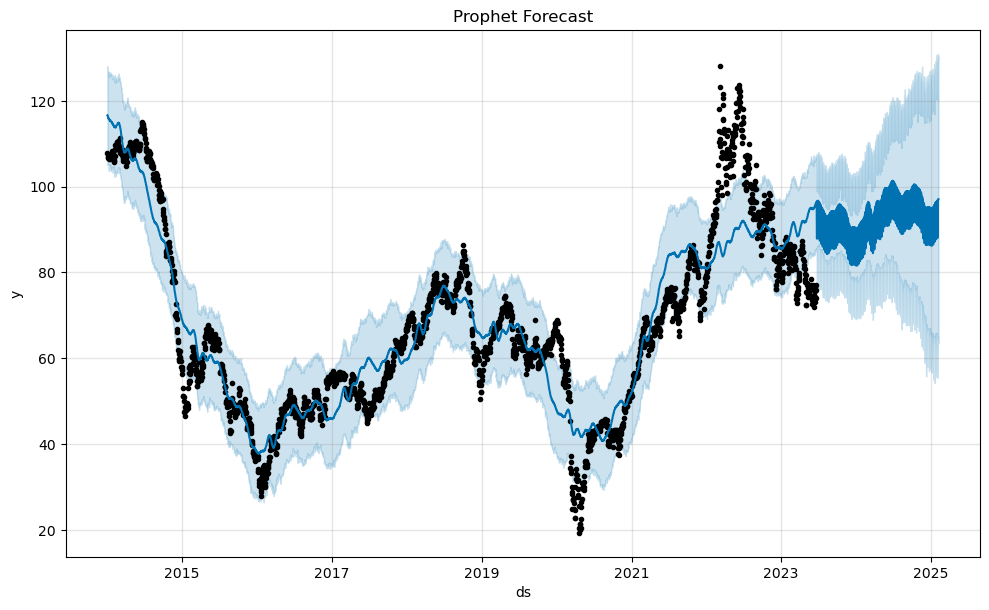

In [37]:
# Plot
m.plot(forecast); plt.title('Prophet Forecast')

20:57:32 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing


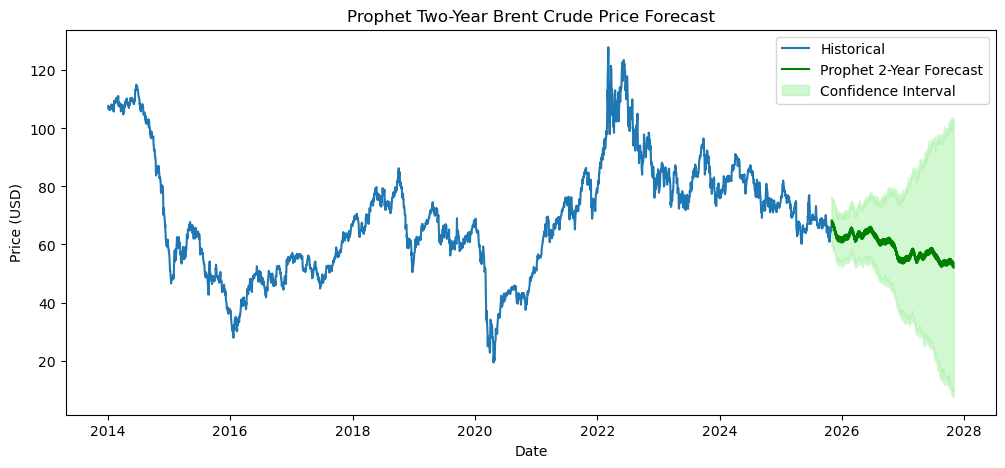

In [38]:
# --- Prophet Two-Year Forecast ---

# Prepare data
prophet_df = df[['Close']].reset_index().rename(
    columns={'Date':'ds', 'Close':'y'}
)

# Fit Prophet on full data
m = Prophet(daily_seasonality=True)
m.fit(prophet_df)

# Create future dataframe for 2 years
future = m.make_future_dataframe(periods=730)
forecast_2yr = m.predict(future)

# Extract future forecasts only
prophet_2yr = forecast_2yr.tail(730)

# Plot
plt.figure(figsize=(12,5))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical')
plt.plot(prophet_2yr['ds'], prophet_2yr['yhat'], label='Prophet 2-Year Forecast', color='green')
plt.fill_between(
    prophet_2yr['ds'],
    prophet_2yr['yhat_lower'],
    prophet_2yr['yhat_upper'],
    color='lightgreen',
    alpha=0.4,
    label='Confidence Interval'
)
plt.title('Prophet Two-Year Brent Crude Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [56]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Prepare Prophet dataframe
df_prophet = df[['Close']].reset_index().rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

# Train-test split (time-based)
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size].copy()
test_prophet = df_prophet.iloc[train_size:].copy()
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m.fit(train_prophet)
future = m.make_future_dataframe(
    periods=len(test_prophet),
    freq='D'
)

forecast = m.predict(future)
# Merge forecast with test dates
prophet_eval = pd.merge(
    test_prophet[['ds', 'y']],
    forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)

# Drop missing predictions
prophet_eval = prophet_eval.dropna()
rmse_prophet = np.sqrt(
    mean_squared_error(prophet_eval['y'], prophet_eval['yhat'])
)

mae_prophet = mean_absolute_error(
    prophet_eval['y'], prophet_eval['yhat']
)

print("Prophet Model Performance:")
print("RMSE:", rmse_prophet)
print("MAE :", mae_prophet)



21:01:01 - cmdstanpy - INFO - Chain [1] start processing
21:01:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance:
RMSE: 16.355091881412147
MAE : 14.874678535156962


In [40]:
# 10. XGBoost (supervised with lag features)


lags = 30
horizon = 1
sup_all = make_supervised(df['Close'], lags=lags, horizon=horizon).dropna()
# train/test on index
train_sup = sup_all.iloc[:len(sup_all)*80//100]
test_sup = sup_all.iloc[len(sup_all)*80//100:]


X_train = train_sup[[f'lag_{i}' for i in range(1,lags+1)]].values
y_train = train_sup['y_plus_1'].values
X_test = test_sup[[f'lag_{i}' for i in range(1,lags+1)]].values
y_test = test_sup['y_plus_1'].values

In [41]:
# Scale
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


xgb_reg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05)
xgb_reg.fit(X_train_s, y_train)


xgb_pred = xgb_reg.predict(X_test_s)
# Map predictions back to series with test index
xgb_pred_series = pd.Series(xgb_pred, index=test_sup.index)

In [42]:
# Align with original test index for evaluation
xgb_metrics = evaluate_forecasts(y_test, xgb_pred)
print('XGBoost metrics:', xgb_metrics)

XGBoost metrics: {'rmse': np.float64(2.271791063131707), 'mae': 1.7121950936438879}


In [43]:
# --- Prepare data for GRU: use close only and scale ---
series = df['Close'].values.reshape(-1,1)
scaler_gru = MinMaxScaler()
series_scaled = scaler_gru.fit_transform(series)

# --- Function to create sequences ---
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# --- Create sequences ---
SEQ_LEN = 30
X, y = create_sequences(series_scaled, seq_len=SEQ_LEN)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (2945, 30, 1), y shape: (2945, 1)


In [44]:
# split
train_size = int(0.8*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [45]:
# Model
tf.keras.backend.clear_session()
model = Sequential([
GRU(64, input_shape=(SEQ_LEN,1), return_sequences=False),
Dense(32, activation='relu'),
Dense(1)
])
model.compile(optimizer='adam', loss='mse')


es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es], verbose=1)



C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0246 - val_loss: 5.7996e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.9386e-04 - val_loss: 5.6184e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.2987e-04 - val_loss: 5.2099e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.2112e-04 - val_loss: 5.2617e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 3.0005e-04 - val_loss: 5.3255e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9091e-04 - val_loss: 4.8651e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.7586e-04 - val_loss: 4.6181e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.7352e-04 - val_loss: 4.2859e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.8230e-04 - val_loss: 4.1939e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6515e-04 - val_loss: 4.7023e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.

In [46]:
# --- Predict with GRU ---
gru_pred_scaled = model.predict(X_test)
gru_pred = scaler_gru.inverse_transform(gru_pred_scaled).flatten()

# Build true y_test unscaled
y_test_unscaled = scaler_gru.inverse_transform(y_test).flatten()

# --- 12. Multi-step (7-day) forecasting with recursive strategy using GRU ---
# We'll forecast last part of dataset sequentially using trained GRU

def recursive_forecast(model, recent_window, steps):
    """
    model: trained GRU model
    recent_window: scaled shape (seq_len, 1)
    steps: number of steps to forecast
    """
    preds = []
    window = recent_window.copy()
    for _ in range(steps):
        p = model.predict(window.reshape(1, window.shape[0], 1))[0,0]
        preds.append(p)
        # append p and drop first
        window = np.vstack([window[1:], [[p]]])
    return np.array(preds)

# --- Evaluate one-step GRU predictions ---
gru_metrics = evaluate_forecasts(y_test_unscaled, gru_pred)
print('GRU metrics:', gru_metrics)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 
GRU metrics: {'rmse': np.float64(1.3856104905009905), 'mae': 1.0469459702082118}


Text(0.5, 1.0, 'GRU Loss')

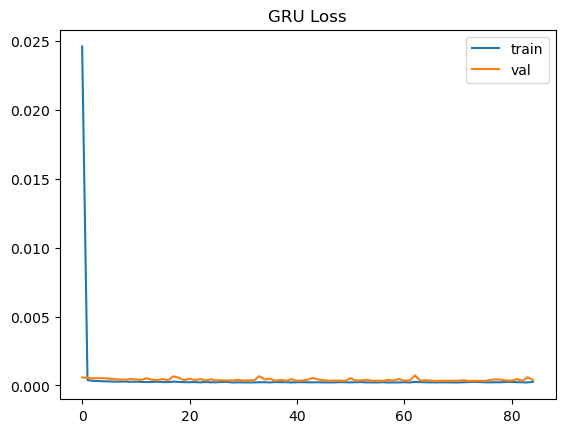

In [47]:
# Plot training loss
plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.legend(); plt.title('GRU Loss')

In [48]:
def recursive_forecast(model, recent_window, steps):
    # recent_window: scaled shape (seq_len, 1)
    preds = []
    window = recent_window.copy()
    
    for _ in range(steps):
        p = model.predict(window.reshape(1, window.shape[0], 1))[0, 0]
        preds.append(p)
        # append p and drop first
        window = np.vstack([window[1:], [[p]]])
        
    return np.array(preds)


In [49]:
# --- Create DataFrame for ensemble evaluation ---
pred_df = pd.DataFrame(index=test.index)  # base index = test set

# actual values
pred_df['actual'] = test['Close']

# Add SARIMA predictions
pred_df['sarima'] = sarima_pred

# Add Prophet predictions (safely aligned with test set)
prophet_series = pd.Series(forecast.set_index('ds')['yhat'])
prophet_series = prophet_series.reindex(pred_df.index)  # align dates with test
pred_df['prophet'] = prophet_series

# Add XGBoost predictions (aligned to the last part of test)
xgb_series_full = pd.Series(xgb_pred, index=test_sup.index)
pred_df.loc[pred_df.index[-len(xgb_series_full):], 'xgb'] = xgb_series_full.values


In [50]:
# take most recent window from end of X (scaled)
recent_window = X[-1].copy() # last available sequence
steps=7
multi_scaled = recursive_forecast(model, recent_window, steps)
multi_pred = scaler_gru.inverse_transform(multi_scaled.reshape(-1,1)).flatten()
print('7-day recursive GRU forecast:', multi_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
7-day recursive GRU forecast: [64.898125 64.86723  64.838585 64.81272  64.786835 64.761116 64.73569 ]


In [51]:
# 13. Volatility: GARCH example (optional)


returns = 100*df['Close'].pct_change().dropna()
am = arch_model(returns, vol='Garch', p=1, q=1)
res_garch = am.fit(disp='off')
print(res_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6360.41
Distribution:                  Normal   AIC:                           12728.8
Method:            Maximum Likelihood   BIC:                           12752.8
                                        No. Observations:                 2974
Date:                Mon, Dec 15 2025   Df Residuals:                     2973
Time:                        21:00:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0364  3.370e-02      1.081      0.280 [-2.96

In [52]:
# Forecast volatility (1 step)
vol_forecast = res_garch.forecast(horizon=1).variance.iloc[-1,0]
print('Forecasted next-day variance (percent-squared):', vol_forecast)

Forecasted next-day variance (percent-squared): 3.8122701615800407


Forecasted next-day variance (percent-squared): 3.8122701615800407


21:00:54 - cmdstanpy - INFO - Chain [1] start processing
21:00:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet metrics: {'rmse': np.float64(16.728067577231354), 'mae': 15.243725394438178}
Ensemble metrics: {'rmse': np.float64(8.275517365296002), 'mae': 6.8579714063796935}


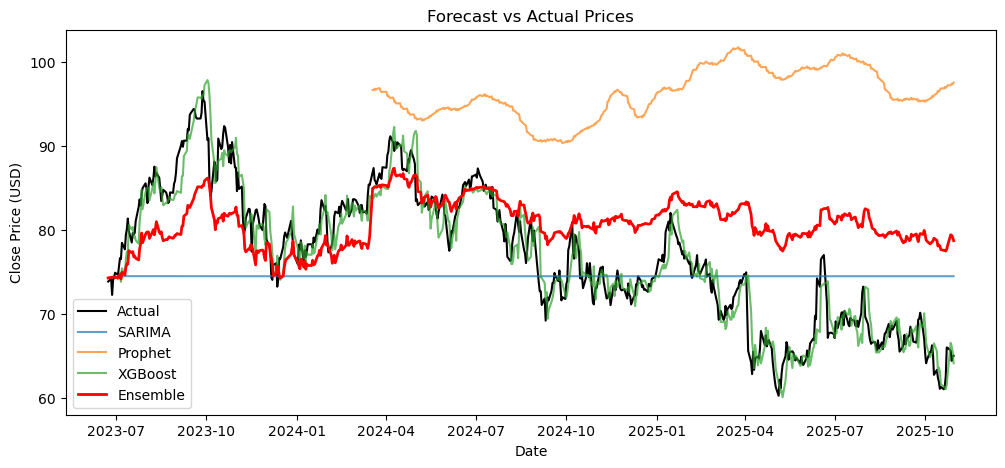

In [53]:
# --- 13. Volatility: GARCH forecast (already done) ---
returns = 100 * df['Close'].pct_change().dropna()
am = arch_model(returns, vol='Garch', p=1, q=1)
res_garch = am.fit(disp='off')

# Forecast volatility (1 step)
vol_forecast = res_garch.forecast(horizon=1).variance.iloc[-1, 0]
print('Forecasted next-day variance (percent-squared):', vol_forecast)

# --- 14. Prophet predictions ---
prophet_df = df[['Close']].reset_index().rename(columns={'Date':'ds', 'Close':'y'})
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Fit Prophet model
m = Prophet(daily_seasonality=True)
m.fit(train_prophet)

# Forecast for the test period
future = m.make_future_dataframe(periods=len(test_prophet))
forecast = m.predict(future)

# Align Prophet predictions with test set
prophet_pred = pd.merge(
    test_prophet[['ds']],
    forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)['yhat']

# Drop NaN predictions
mask = ~prophet_pred.isna()
prophet_pred = prophet_pred[mask]
y_true_clean = test_prophet['y'].values[mask]

# Evaluate Prophet forecast
prophet_metrics = evaluate_forecasts(y_true_clean, prophet_pred.values)
print('Prophet metrics:', prophet_metrics)

# --- 15. Prepare ensemble dataframe ---
pred_df = pd.DataFrame(index=test.index)
pred_df['actual'] = test['Close']

# Add SARIMA predictions
pred_df['sarima'] = sarima_pred

# Add Prophet predictions aligned with the end of test set
pred_df['prophet'] = pd.Series(prophet_pred.values, index=pred_df.index[-len(prophet_pred):])

# Add XGBoost predictions aligned with the end of test set
pred_df['xgb'] = pd.Series(xgb_pred, index=pred_df.index[-len(xgb_pred):])

# Compute ensemble mean
pred_df['ensemble_mean'] = pred_df[['sarima','prophet','xgb']].mean(axis=1)

# Evaluate ensemble
ensemble_metrics = evaluate_forecasts(pred_df['actual'].dropna(), pred_df['ensemble_mean'].dropna())
print('Ensemble metrics:', ensemble_metrics)

# --- Optional: Plot actual vs forecasts ---
plt.figure(figsize=(12,5))
plt.plot(pred_df['actual'], label='Actual', color='black')
plt.plot(pred_df['sarima'], label='SARIMA', alpha=0.7)
plt.plot(pred_df['prophet'], label='Prophet', alpha=0.7)
plt.plot(pred_df['xgb'], label='XGBoost', alpha=0.7)
plt.plot(pred_df['ensemble_mean'], label='Ensemble', color='red', linewidth=2)
plt.title('Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


In [57]:
def evaluate_forecasts(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


In [58]:
rmse_naive, mae_naive = evaluate_forecasts(
    test['Close'], naive_pred
)


In [59]:
rmse_roll, mae_roll = evaluate_forecasts(
    test['Close'], rolling_pred_series
)


In [60]:
rmse_sarima, mae_sarima = evaluate_forecasts(
    test['Close'], sarima_pred
)


In [67]:
rmse_prophet, mae_prophet = evaluate_forecasts(
    prophet_eval['y'], prophet_eval['yhat']
)
print(rmse_prophet, mae_prophet)

16.355091881412147 14.874678535156962


In [62]:
rmse_xgb, mae_xgb = evaluate_forecasts(
    y_test, xgb_pred
)


In [63]:
rmse_gru, mae_gru = evaluate_forecasts(
    y_test_unscaled, gru_pred
)


In [64]:
rmse_ens, mae_ens = evaluate_forecasts(
    pred_df['actual'].dropna(),
    pred_df['ensemble_mean'].dropna()
)


In [68]:
results_table = pd.DataFrame({
    'Model': [
        
        'SARIMA',
        'Prophet',
        
    ],
    'RMSE': [
       
        rmse_sarima,
        rmse_prophet,
       
    ],
    'MAE': [
        mae_sarima,
        mae_prophet,
    ]
})

print("\nTable: Forecast Accuracy Comparison")
print(results_table)



Table: Forecast Accuracy Comparison
     Model       RMSE        MAE
0   SARIMA   8.363822   6.956551
1  Prophet  16.355092  14.874679


In [69]:
results_table.sort_values(by='RMSE')


,Model,RMSE,MAE
0,SARIMA,8.363822,6.956551
1,Prophet,16.355092,14.874679


AttributeError: module 'matplotlib.pyplot' has no attribute 'tight'

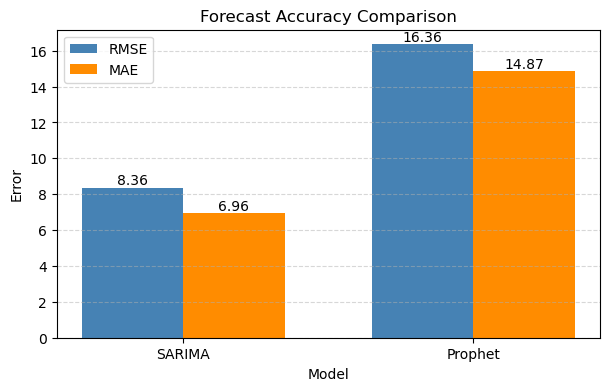

In [78]:
import matplotlib.pyplot as plt
import numpy as np

models = results_table['Model'].values
rmse = results_table['RMSE'].values
mae = results_table['MAE'].values

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(7,4))
plt.bar(x - width/2, rmse, width, label='RMSE', color='steelblue')
plt.bar(x + width/2, mae, width, label='MAE', color='darkorange')

# Labels, title, legend
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Forecast Accuracy Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for i in range(len(models)):
    plt.text(x[i] - width/2, rmse[i], f'{rmse[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, mae[i], f'{mae[i]:.2f}', ha='center', va='bottom')

plt.tight


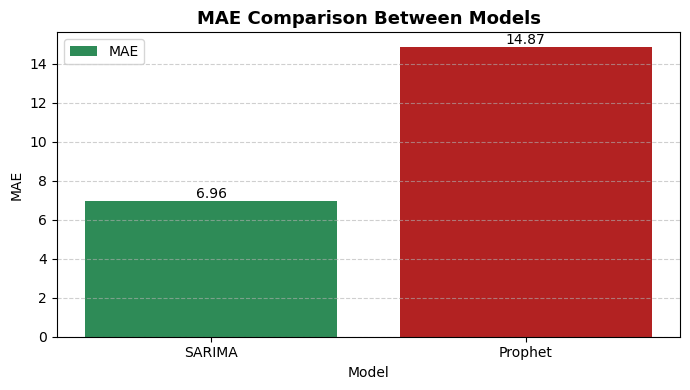

In [74]:
plt.figure(figsize=(7,4))

plt.bar(
    results_table['Model'],
    results_table['MAE'],
    color=['seagreen', 'firebrick'],
    label='MAE'
)

plt.title('MAE Comparison Between Models', fontsize=13, fontweight='bold')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Value labels
for i, v in enumerate(results_table['MAE']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [66]:
# 14. Ensemble: simple average of predictions (where possible)
pred_df = pd.DataFrame(index=test.index)
pred_df['actual'] = test['Close']

# Add SARIMA
pred_df['sarima'] = sarima_pred

# Add Prophet safely aligned
prophet_series = pd.Series(forecast.set_index('ds')['yhat']).reindex(pred_df.index)
pred_df['prophet'] = prophet_series

# Add XGBoost: align using last N predictions
xgb_series_full = pd.Series(xgb_pred, index=range(len(xgb_pred)))
pred_df.loc[pred_df.index[-len(xgb_series_full):], 'xgb'] = xgb_series_full.values

# Ensemble mean
pred_df['ensemble_mean'] = pred_df[['sarima','prophet','xgb']].mean(axis=1)

# Metrics
ensemble_metrics = evaluate_forecasts(pred_df['actual'].dropna(), pred_df['ensemble_mean'].dropna())
print('Ensemble metrics (mean of available):', ensemble_metrics)


Ensemble metrics (mean of available): {'rmse': np.float64(4.936923088755569), 'mae': 4.0388898555965635}


In [67]:
# Ensemble mean across available models
pred_df['ensemble_mean'] = pred_df[['sarima','prophet','xgb']].mean(axis=1)
ensemble_metrics = evaluate_forecasts(pred_df['actual'].dropna(), pred_df['ensemble_mean'].dropna())
print('Ensemble metrics (mean of available):', ensemble_metrics)

Ensemble metrics (mean of available): {'rmse': np.float64(4.936923088755569), 'mae': 4.0388898555965635}


In [69]:
# 14. Ensemble: simple average of predictions (where possible)

# Build comparable aligned predictions for the same test set (1-step ahead)
common_index = test_sup.index

pred_df = pd.DataFrame(index=test.index)
pred_df['actual'] = test['Close']

# Add sarima
pred_df['sarima'] = sarima_pred

# Add prophet safely aligned with test set
prophet_series = pd.Series(forecast.set_index('ds')['yhat'])   # full forecast
prophet_series = prophet_series.reindex(pred_df.index)          # keep only test dates
pred_df['prophet'] = prophet_series

# Add xgb: map using last len(xgb_pred_series) dates
xgb_series_full = pd.Series(xgb_pred, index=test_sup.index)
if len(xgb_series_full) <= len(pred_df):
    pred_df.loc[pred_df.index[-len(xgb_series_full):], 'xgb'] = xgb_series_full.values


In [70]:
print(pred_df)

               actual     sarima    prophet        xgb
Date                                                  
2023-06-23  73.849998  74.279746  96.676637        NaN
2023-06-26  74.180000  74.347067  96.676819        NaN
2023-06-27  72.260002  74.368219  96.844683        NaN
2023-06-28  74.029999  74.376502  96.699554        NaN
2023-06-29  74.339996  74.397144  96.803853        NaN
...               ...        ...        ...        ...
2025-10-24  65.940002  74.486439        NaN  62.889038
2025-10-27  65.620003  74.486439        NaN  66.548790
2025-10-28  64.400002  74.486439        NaN  66.111198
2025-10-29  64.919998  74.486439        NaN  65.489983
2025-10-30  65.000000  74.486439        NaN  64.113930

[595 rows x 4 columns]


In [ ]:
# %%
# 16. Final notes & Next steps


notes = '''
Next steps you can take to improve performance:
- Add exogenous variables (USD index, inventory reports, OPEC announcements, demand proxies)
- Use hyperparameter tuning (GridSearch / Optuna) for XGBoost/GRU
- Use better multi-step forecasting strategies (direct vs. multi-output models)
- Use probabilistic forecasting (quantile regression, forecast intervals)
- Experiment with Transformers (Informer/Autoformer) for long sequence forecasts
- Productionize with model monitoring and retraining
'''
print(notes)

In [ ]:
# 14. Ensemble: simple average of predictions
# -----------------------------------------

# Create a DataFrame for predictions
pred_df = pd.DataFrame(index=test.index)
pred_df['actual'] = test['Close']

# Add SARIMA predictions (assume sarima_pred already aligned with test.index)
pred_df['sarima'] = sarima_pred

# Add Prophet predictions safely
# Convert test_prophet 'ds' to datetime and create a Series
prophet_series = pd.Series(prophet_pred.values, index=pd.to_datetime(test_prophet['ds']))
# Keep only dates that are in the test set
common_dates = test.index.intersection(prophet_series.index)
prophet_series = prophet_series.loc[common_dates]
# Reindex to match pred_df.index (NaN for missing dates)
pred_df['prophet'] = prophet_series.reindex(pred_df.index)

# Add XGBoost predictions safely
xgb_series_full = pd.Series(xgb_pred, index=test_sup.index)
if len(xgb_series_full) <= len(pred_df):
    pred_df.loc[pred_df.index[-len(xgb_series_full):], 'xgb'] = xgb_series_full.values

# Add GRU predictions safely (assuming gru_pred already exists for the test set)
gru_series_full = pd.Series(gru_pred, index=y_test.index)
pred_df.loc[pred_df.index[-len(gru_series_full):], 'gru'] = gru_series_full.values

# Compute ensemble as simple average of available predictions
pred_df['ensemble'] = pred_df[['sarima', 'prophet', 'xgb', 'gru']].mean(axis=1, skipna=True)

# Optional: check the resulting DataFrame
print(pred_df.head())

In [ ]:
# RMSE Bar Plot
plt.figure(figsize=(12,6))
plt.bar(metrics_df['Model'], metrics_df['RMSE'])
plt.title('Model Comparison (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(metrics_df['Model'], metrics_df['MAE'])
plt.title('Model Comparison (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()